In [ ]:
import requests
import pandas as pd
import seaborn as sns
import string
import re
import numpy as np
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate
from collections import Counter
import pickle
from joblib import dump, load

In [ ]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 95.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Функция для получения отзывов из сообщества Steam, использует веб-API Steamworks. Возвращает таблицу с 15 колонками:

1. recommendationid - Уникальный ID рекомендации
2. author - Информация об авторе обзора
  2.1. steamid — SteamID пользователя
  2.2. num_games_owned — число игр, которыми владеет пользователь
  2.3. num_reviews — число обзоров, написанных пользователем
  2.4. playtime_forever — время, проведённое в этом приложении за всё время
  2.5. playtime_last_two_weeks — время, проведённое в этом приложении за две последние недели
  2.6. playtime_forever — время, проведённое в приложении на момент написания обзора
  2.7. deck_playtime_at_review — время, проведённое на Steam Deck на момент написания обзора
  2.8. last_played — время, когда пользователь запускал приложение в последний раз
3. language - Язык, указанный пользователем при написании обзора
4. review - Текст обзора
5. timestamp_created - Дата создания обзора в формате UNIX
6. timestamp_updated - Дата последнего изменения обзора в формате UNIX
7. voted_up - Значение true означает, что обзор положительный
8. votes_up - Число пользователей, посчитавших обзор полезным
9. votes_funny - Число пользователей, посчитавших обзор забавным
10. weighted_vote_score - Рейтинг полезности
11. comment_count - Число комментариев к этому обзору
12. steam_purchase - true, если пользователь купил игру в Steam
13. received_for_free - true, если пользователь поставил галочку, означающую, что он получил приложение бесплатно
14. written_during_early_access - true, если обзор написан, когда игра была в раннем доступе
15. primarily_steam_deck - Играл ли пользователь в эту игру в основном на Steam Deck на момент написания обзора

В качестве аргументов функция принимает id игры, число отзывов, которое будет в итоговой таблице, и язык, на котором написаны обзоры. Если указанное число отзывов превышает число отзывов в Steam, то некоторые отзывы будут продублированы.

In [ ]:
def get_reviews(appid: str, num_reviews: int = 1000, language: str = 'english') -> pd.DataFrame:
    reviews = []
    cursor = '*'
    params = {
        'json': 1,
        'filter': 'all',
        'language': language,
        'day_range': 365,
        'review_type': 'all',
        'purchase_type': 'all'
    }

    while len(reviews) < num_reviews:
        params['cursor'] = cursor
        params['num_per_page'] = min(100, num_reviews - len(reviews))
        response = requests.get(
            url=f'https://store.steampowered.com/appreviews/{appid}',
            params=params
        )
        data = response.json()
        reviews.extend(data.get('reviews', []))
        cursor = data.get('cursor')
        if not cursor:
            break

    return pd.DataFrame(reviews)

In [ ]:
dfappid = input("Введите Steam AppID (цифры): ")
print("Загружаю отзывы... это может занять некоторое время.")
df = get_reviews(appid, num_reviews=150000)
print(f"Загружено отзывов: {len(df)}")
df.to_csv(f"steam_reviews_{appid}.csv", index=False)
print("Сохранено в CSV.").head()

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,primarily_steam_deck
0,196369189,"{'steamid': '76561198044140908', 'num_games_ow...",english,Game is good but please add more crossover bos...,1749030168,1749030168,True,662,6,0.949646,0,True,False,False,False
1,196117089,"{'steamid': '76561198147565758', 'num_games_ow...",english,So after playing this for two days straight si...,1748738915,1749051920,True,1858,30,0.945383,0,False,False,False,False
2,196052526,"{'steamid': '76561199079305990', 'num_games_ow...",english,add duo/communication and cross play and it wi...,1748680754,1748680754,True,3498,39,0.939147,0,True,False,False,False
3,195936698,"{'steamid': '76561198148218102', 'num_games_ow...",english,"They did this. After defeating Radahn, Malenia...",1748565950,1748565950,True,297,109,0.934784,0,True,False,False,False
4,197108770,"{'steamid': '76561198382246894', 'num_games_ow...",english,It was fun experiencing this new style of play...,1749797048,1749797048,True,319,9,0.928014,7,True,False,False,False


 Чтобы постоянно не загружать наборы данных, было принято решение сохранить все полученные данные в формат csv. Таким образом при повторных запусках кода не придется заново получать все обзоры через API. Сохраненные наборы данных лежат в папке data

In [ ]:
EldenRing_df = pd.read_csv('./data/steam_reviews_EldenRing.csv')
EldenRingDLC_df = pd.read_csv('./data/steam_reviews_EldenRingDLC.csv')
EldenRingNightreign_df = pd.read_csv('./data/steam_reviews_EldenRingNightreign.csv')

dfs = [EldenRing_df, EldenRingDLC_df, EldenRingNightreign_df]

In [ ]:
EldenRing_df.info()

In [ ]:
EldenRingDLC_df.info()

,review,voted_up,timestamp_created,timestamp_updated
0,Game is good but please add more crossover bos...,True,1749030168,1749030168
1,So after playing this for two days straight si...,True,1748738915,1749051920
2,add duo/communication and cross play and it wi...,True,1748680754,1748680754
3,"They did this. After defeating Radahn, Malenia...",True,1748565950,1748565950
4,It was fun experiencing this new style of play...,True,1749797048,1749797048


In [ ]:
EldenRingNightreign_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   review             149520 non-null  object
 1   voted_up           150000 non-null  bool  
 2   timestamp_created  150000 non-null  int64 
 3   timestamp_updated  150000 non-null  int64 
dtypes: bool(1), int64(2), object(1)
memory usage: 3.6+ MB


In [ ]:
sns.countplot(reviews_df, x='length')

SyntaxError: invalid syntax (ipython-input-1787819150.py, line 1)

In [ ]:
reviews_df['length'].describe()

,voted_up
count,73851
unique,2
top,True
freq,63631


In [ ]:
reviews_df.dropna(inplace=True)

In [ ]:
reviews_df.drop_duplicates(inplace=True)

In [ ]:
reviews_df.shape

(73800, 4)

In [ ]:
reviews_df['timestamp_created'] = pd.to_datetime(reviews_df['timestamp_created'], unit='s')

In [ ]:
reviews_df['timestamp_updated'] = pd.to_datetime(reviews_df['timestamp_updated'], unit='s')

In [ ]:
reviews_df

,review,voted_up,timestamp_created,timestamp_updated
0,Game is good but please add more crossover bos...,True,2025-06-04 09:42:48,2025-06-04 09:42:48
1,So after playing this for two days straight si...,True,2025-06-01 00:48:35,2025-06-04 15:45:20
2,add duo/communication and cross play and it wi...,True,2025-05-31 08:39:14,2025-05-31 08:39:14
3,"They did this. After defeating Radahn, Malenia...",True,2025-05-30 00:45:50,2025-05-30 00:45:50
4,It was fun experiencing this new style of play...,True,2025-06-13 06:44:08,2025-06-13 06:44:08
...,...,...,...,...
143727,[h1] CINEMA [/h1],True,2025-06-01 10:42:57,2025-08-08 20:52:42
143784,peak,True,2025-06-09 15:17:52,2025-06-09 15:17:52
143823,Nightpain,True,2025-06-27 09:02:39,2025-06-27 09:02:39
144047,dumbahh augur,True,2025-06-05 14:13:24,2025-06-05 14:13:24


<Axes: xlabel='voted_up', ylabel='count'>

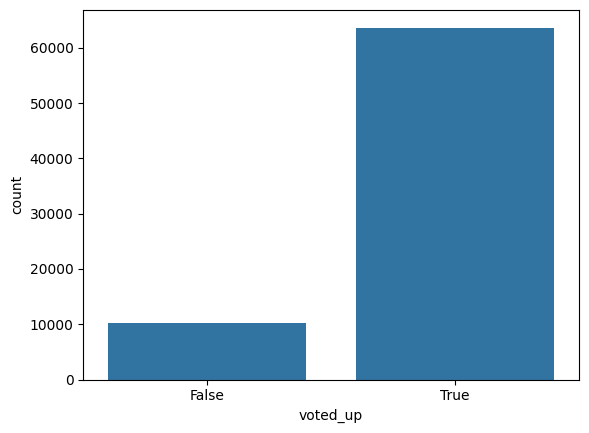

In [ ]:
sns.countplot(data=reviews_df, x='voted_up')

In [ ]:
url_pattern = re.compile(r'https?://\S+')
html_pattern = re.compile(r'\[[/A-Za-z0-9\*]+\]')

def remove_noise(text: str) -> str:
    text_without_urls = url_pattern.sub('', text)
    text_without_html = html_pattern.sub('', text_without_urls)
    return text_without_html.replace('\n', ' ').replace('\t', ' ').replace('\r', ' ')

reviews_df['review'] = reviews_df['review'].apply(remove_noise)

In [ ]:
def preprocess(text: str, stop_words: list[str], punctuation_marks: list[str], morph):
    tokens = word_tokenize(text.lower())
    preprocessed_text = []
    for token in tokens:
        if token not in punctuation_marks:
            lemma = morph(token)[0].lemma_
            if lemma not in stop_words and lemma not in punctuation_marks:
                preprocessed_text.append(lemma)
    return preprocessed_text

In [ ]:
punctuation_marks = string.punctuation
punctuation_marks_list = [char for char in punctuation_marks]
punctuation_marks_list.extend(['...', '..'])

nlp = spacy.load("en_core_web_sm")

stop_words = stopwords.words('english')

In [ ]:
# reviews_df['preprocessed_reviews'] = reviews_df['review_no_ss'].apply(lambda row: preprocess(row,stop_words,punctuation_marks, nlp))

In [ ]:
reviews_df['length'] = reviews_df['review'].apply(lambda x: len(x))

mid_length_df = reviews_df[(reviews_df['length'] < 100) & (reviews_df['length'] > 10)].copy()

sorted_by_voted_df = mid_length_df.sort_values(by='voted_up')

balanced_df = pd.concat([sorted_by_voted_df.head(2500), sorted_by_voted_df.tail(2500)])
balanced_df['voted_up'].value_counts()

,count
voted_up,
False,2500
True,2500


In [ ]:
mid_length_df.shape

(32792, 5)

In [ ]:
from tqdm import tqdm
tqdm.pandas()

balanced_df['preprocessed_reviews'] = balanced_df['review'].progress_apply(lambda row: preprocess(row,stop_words,punctuation_marks, nlp))

100%|██████████| 5000/5000 [04:55<00:00, 16.95it/s]


In [ ]:
words = Counter()

In [ ]:
for txt in balanced_df['preprocessed_reviews']:
  words.update(txt)

In [ ]:
word_to_index = dict()
index_to_word = dict()

In [ ]:
for i, word in enumerate(words.most_common(10000-2)):
  word_to_index[word[0]] = i+2
  index_to_word[i+2] = word[0]


In [ ]:
def text_to_sequence(txt, word_to_index):
  seq = []
  for word in txt:
    index = word_to_index.get(word,1)

    if index != 1:
      seq.append(index)
  return seq

In [ ]:
balanced_df['Sequences'] = balanced_df['preprocessed_reviews'].apply(lambda x: text_to_sequence(x, word_to_index))

In [ ]:
balanced_df

,review,voted_up,timestamp_created,timestamp_updated,length,preprocessed_reviews,Sequences
43224,Biggest Flop of the entire company,False,2025-05-30 07:26:29,2025-05-30 07:26:29,34,"[big, flop, entire, company]","[83, 1250, 426, 826]"
30862,This game is soooo mid. I played a total of 9....,False,2025-05-30 16:31:21,2025-06-23 13:47:14,75,"[game, soooo, mid, I, play, total, 9.4, hrs, s...","[2, 1751, 191, 3, 5, 1251, 1752, 975, 366, 148..."
58231,we dont like fortnite!,False,2025-06-13 08:38:15,2025-06-13 08:38:15,22,"[like, fortnite]","[10, 42]"
30856,Matchmaking straight up doesn't work if you ha...,False,2025-05-30 21:09:51,2025-05-30 21:09:51,85,"[matchmaking, straight, work, two, people, mat...","[101, 318, 90, 167, 66, 1754, 456]"
30855,shıt game shıt op shıt servers shıt ac shıt bo...,False,2025-05-30 21:43:02,2025-05-30 21:43:02,50,"[shıt, game, shıt, op, shıt, server, shıt, ac,...","[726, 2, 726, 427, 726, 43, 726, 1755, 726, 15]"
...,...,...,...,...,...,...,...
38337,did we kill the nightlord no that was just ...,True,2025-05-30 06:37:08,2025-05-30 06:37:08,58,"[kill, nightlord, albinauric]","[130, 223, 4059]"
38336,Very fun to play with friends,True,2025-05-30 06:47:58,2025-05-30 06:47:58,29,"[fun, play, friend]","[4, 5, 9]"
38335,Really fun! Better with friends though.,True,2025-05-30 07:21:44,2025-05-30 07:21:44,39,"[really, fun, well, friend, though]","[29, 4, 19, 9, 152]"
38299,40€ and Lots of pain 10/10 Worth every cent,True,2025-05-30 19:37:33,2025-05-30 19:37:33,44,"[40, lot, pain, 10/10, worth, every, cent]","[73, 87, 745, 23, 50, 72, 4060]"


In [ ]:
balanced_df['voted_up'] = balanced_df['voted_up'].astype(int)

In [ ]:
train, test = train_test_split(balanced_df, test_size=0.2)

In [ ]:
x_train_seq = train['Sequences']
y_train = train['voted_up']

x_test_seq = test['Sequences']
y_test = test['voted_up']

In [ ]:
def vectorize_sequences(sequences, dimension=10000):
  result = np.zeros((len(sequences),dimension))
  for i, sequence in enumerate(sequences):
    for index in sequence:
      result[i,index] += 1
  return result

In [ ]:
x_train = vectorize_sequences(x_train_seq)

In [ ]:
x_test = vectorize_sequences(x_test_seq)

In [ ]:
lr = LogisticRegression(random_state=42,max_iter=500)

In [ ]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB

gnb = GaussianNB()
bnb = BernoulliNB()

In [ ]:
from sklearn import svm

clf = svm.SVC()

In [ ]:
X  = np.vstack([x_train, x_test])
# y = np.vstack([y_train, y_test])
X.shape

(5000, 10000)

In [ ]:
y_train_1 = np.reshape(y_train,(4000, 1))
y_test_1 = np.reshape(y_test, (1000,1))
y = np.vstack([y_train_1, y_test_1])

In [ ]:
y = np.reshape(y, (5000))

In [ ]:
cv_results = cross_validate(clf, X, y)
sorted(cv_results.keys())

['fit_time', 'score_time', 'test_score']

In [ ]:
cv_results['test_score']

array([0.78 , 0.799, 0.783, 0.807, 0.787])

In [ ]:
lr.fit(x_train,y_train)

LogisticRegression(max_iter=1000, random_state=48)

In [ ]:
lr.score(x_test,y_test)

0.799

In [ ]:
# dump(lr, 'LogisticRegression.joblib')

['LogisticRegression.joblib']

In [ ]:
new_lr = load('/content/LogisticRegression.joblib')

In [ ]:
new_lr.score(x_test,y_test)

0.818

In [ ]:
def predict(texts):
  result = []
  for text in texts:
    text_preprocessed = preprocess(text,punctuation_marks_list,stop_words,nlp)
    sequenced_text = text_to_sequence(text_preprocessed,word_to_index)
    text_bow = vectorize_sequences([sequenced_text])
    result.append(lr.predict(text_bow)[0])
  return result

In [ ]:
task1 = reviews_df.sort_values(by='voted_up').values[25000]
task2 = reviews_df.sort_values(by='voted_up').values[1000]
(task1, task2)

(array(['pink hole', True, Timestamp('2025-06-06 07:55:45'),
        Timestamp('2025-06-06 07:55:45'), 9], dtype=object),
 array(["Kernel level anti-cheat IN A PVE ONLY game 60fps cap no ultrawide huge controller deadzones that cannot be adjusted no map legend extreme lack of random elements in a ROUGELIKE  There is a lot of problems with this game, but buying a game that was CLEARLY ADVERTISED to you and complaining it's not the game you WANTED it to be is not one of them.",
        False, Timestamp('2025-05-30 16:11:11'),
        Timestamp('2025-05-30 16:11:11'), 347], dtype=object))

In [ ]:
sentence1 = task1[0]
sentence2 = task2[0]
sentence2

"Kernel level anti-cheat IN A PVE ONLY game 60fps cap no ultrawide huge controller deadzones that cannot be adjusted no map legend extreme lack of random elements in a ROUGELIKE  There is a lot of problems with this game, but buying a game that was CLEARLY ADVERTISED to you and complaining it's not the game you WANTED it to be is not one of them."

In [ ]:
y_pred = predict(mid_length_df['review'])

In [ ]:
mid_length_df['y_pred'] = y_pred

In [ ]:
mid_length_df['voted_up'] = mid_length_df['voted_up'].astype(int)

In [ ]:
mid_length_df['is_correct'] = mid_length_df['voted_up'] == mid_length_df['y_pred']

In [ ]:
mid_length_df['is_correct'].value_counts()

,count
is_correct,
True,24222
False,8570


In [ ]:
mid_length_df

,review,voted_up,timestamp_created,timestamp_updated,length,y_pred,is_correct
2,add duo/communication and cross play and it wi...,1,2025-05-31 08:39:14,2025-05-31 08:39:14,59,0,False
6,Very fun game just wish there was a better sea...,1,2025-07-20 03:48:51,2025-07-20 03:48:51,69,1,True
15,i like this game but they should add kissing o...,1,2025-07-08 15:19:44,2025-07-08 15:19:44,91,0,False
16,amazing game but add more maps or something li...,1,2025-06-01 19:41:58,2025-06-01 19:41:58,76,1,True
21,After playing it for a bit and getting a bette...,1,2025-06-03 00:37:24,2025-06-03 00:37:24,80,1,True
...,...,...,...,...,...,...,...
113761,Seamless Coop: Prepare to Pay Edition,1,2025-05-29 22:24:57,2025-05-29 22:24:57,37,0,False
113768,ez ahh game on jah frfr i be playin an gamin t...,1,2025-08-09 02:45:34,2025-08-09 02:45:34,66,0,False
113785,Try finger but no hole :( Only Night but rain,1,2025-08-12 08:14:14,2025-08-12 08:14:14,45,1,True
113801,It's no Elden Ring but it's still Elden Ring.,1,2025-06-11 04:33:47,2025-06-11 04:33:47,45,1,True


In [ ]:
appid = '1245620'
eldenRing_df = get_reviews(appid, num_reviews=50000)
print(f"Загружено отзывов: {len(eldenRing_df)}")
eldenRing_df.to_csv(f"steam_reviews_{appid}.csv", index=False)

Загружено отзывов: 50000


In [ ]:
appid = '2778580'
eldenRingDLC_df = get_reviews(appid, num_reviews=50000)
print(f"Загружено отзывов: {len(eldenRingDLC_df)}")
eldenRingDLC_df.to_csv(f"steam_reviews_{appid}.csv", index=False)

Загружено отзывов: 50000


In [ ]:
eldenRingDLC_df['length'] = eldenRingDLC_df['review'].apply(lambda x: len(x))
eldenRingDLC_mid_df = eldenRingDLC_df[(eldenRingDLC_df['length'] > 10) & (eldenRingDLC_df['length'] < 100)]

eldenRing_df['length'] = eldenRing_df['review'].apply(lambda x: len(x))
eldenRing_mid_df = eldenRing_df[(eldenRing_df['length'] > 10) & (eldenRing_df['length'] < 100)]


In [ ]:
eldenRing_mid_df['voted_up'].value_counts()

,count
voted_up,
True,27831
False,1397


In [ ]:
eldenRingDLC_mid_df['voted_up'].value_counts()

,count
voted_up,
True,14918
False,3063


In [ ]:
eldenRingDLC_mid_df['predict'] = predict(eldenRingDLC_mid_df['review'])

/tmp/ipython-input-2059683492.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eldenRingDLC_mid_df['predict'] = predict(eldenRingDLC_mid_df['review'])


In [ ]:
eldenRingDLC_mid_df['voted_up'] = eldenRingDLC_mid_df['voted_up'].astype(int)

/tmp/ipython-input-2400257903.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eldenRingDLC_mid_df['voted_up'] = eldenRingDLC_mid_df['voted_up'].astype(int)


In [ ]:
eldenRingDLC_mid_df['is_correct'] = eldenRingDLC_mid_df['voted_up'] == eldenRingDLC_mid_df['predict']

/tmp/ipython-input-1070585697.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eldenRingDLC_mid_df['is_correct'] = eldenRingDLC_mid_df['voted_up'] == eldenRingDLC_mid_df['predict']


In [ ]:
eldenRingDLC_mid_df['is_correct'].value_counts()

,count
is_correct,
True,12070
False,5911


In [ ]:
eldenRing_df['length'] = eldenRing_df['review'].apply(lambda x: len(x)).copy()
eldenRing_mid_df = eldenRing_df[(eldenRing_df['length'] > 10) & (eldenRing_df['length'] < 100)]

In [ ]:
eldenRing_mid_df['predict'] = predict(eldenRing_mid_df['review'])

/tmp/ipython-input-604209310.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eldenRing_mid_df['predict'] = predict(eldenRing_mid_df['review'])


In [ ]:
eldenRing_mid_df['voted_up'] = eldenRing_mid_df['voted_up'].astype(int)

/tmp/ipython-input-135707100.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eldenRing_mid_df['voted_up'] = eldenRing_mid_df['voted_up'].astype(int)


In [ ]:
eldenRing_mid_df['is_correct'] = eldenRing_mid_df['voted_up'] == eldenRing_mid_df['predict']

/tmp/ipython-input-1626554650.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eldenRing_mid_df['is_correct'] = eldenRing_mid_df['voted_up'] == eldenRing_mid_df['predict']


In [ ]:
eldenRing_mid_df['is_correct'].value_counts()

,count
is_correct,
True,19692
False,9536


In [ ]:
eldenRing_mid_df.groupby(['is_correct'])['predict'].value_counts()

is_correct  predict
False       0           9227
            1            309
True        1          18604
            0           1088
Name: count, dtype: int64

In [ ]:
eldenRingDLC_mid_df.groupby(['is_correct'])['predict'].value_counts()

is_correct  predict
False       0          5374
            1           537
True        1          9544
            0          2526
Name: count, dtype: int64

In [ ]:
eldenRingDLC_df['length'].describe()

,length
count,50000.000000
mean,495.251760
std,954.042409
min,1.000000
25%,29.000000
50%,123.000000
75%,527.000000
max,8000.000000


In [ ]:
eldenRing_df['length'].describe()

,length
count,50000.000000
mean,161.409720
std,466.626451
min,0.000000
25%,16.000000
50%,39.000000
75%,107.000000
max,8000.000000
